In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
num_classes = 10
epochs = 5
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

fashionmnist



2024-06-14 07:37:38.282985: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-14 07:37:38.283128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-14 07:37:38.488602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [3]:
data_train_file = "/kaggle/input/fashionmnist/fashion-mnist_train.csv"
data_test_file = "/kaggle/input/fashionmnist/fashion-mnist_test.csv"

df_train = pd.read_csv(data_train_file)
df_test = pd.read_csv(data_test_file)

In [4]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 5x5 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 28, 28, 1]
    # Output Tensor Shape: [batch_size, 28, 28, 32]
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 28, 28, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 5x5 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 14, 14, 32]
    # Output Tensor Shape: [batch_size, 14, 14, 64]
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 14, 14, 64]
    # Output Tensor Shape: [batch_size, 7, 7, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 7, 7, 64]
    # Output Tensor Shape: [batch_size, 7 * 7 * 64]
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Dense Layer
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name="dense1")

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    prediction_output = tf.estimator.export.PredictOutput({
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    })

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                          export_outputs={
                                              tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: prediction_output
                                          })

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)
    
    # Generate some summary info
    tf.summary.scalar('loss', loss)
    tf.summary.histogram('conv1', conv1)
    tf.summary.histogram('dense', dense)

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])
    }
    
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [5]:
df_train[df_train.columns[1:]].values.shape


(60000, 784)

In [6]:
df_test.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_data = np.array(df_train, dtype = 'float32')


In [10]:
test_data = np.array(df_test, dtype='float32')


In [11]:
x_train = train_data[:,1:]/255

y_train = train_data[:,0]

x_test= test_data[:,1:]/255

y_test=test_data[:,0]

In [12]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 12345)


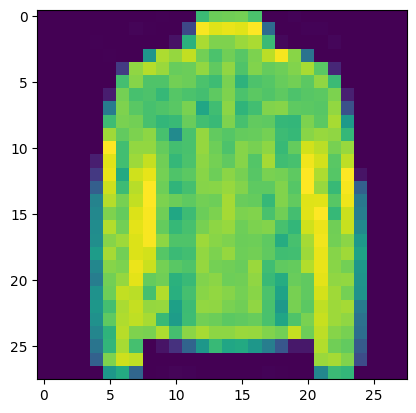

In [13]:
image = x_train[55,:].reshape((28,28))
plt.imshow(image)
plt.show()

In [14]:
image_rows = 28

image_cols = 28

batch_size = 512

image_shape = (image_rows,image_cols,1) # Defined the shape of the image as 3d with rows and columns and 1 for the 3d visualisation

In [15]:
x_train = x_train.reshape(x_train.shape[0],*image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_validate = x_validate.reshape(x_validate.shape[0],*image_shape)

In [16]:
cnn_model = Sequential([
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2) ,# down sampling the output instead of 28*28 it is 14*14
    Dropout(0.2),
    Flatten(), # flatten out the layers
    Dense(32,activation='relu'),
    Dense(10,activation = 'softmax')
    
])

In [18]:
from keras.optimizers import Adam

cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])


In [19]:
history = cnn_model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=1,
    validation_data=(x_validate,y_validate),
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.6271 - loss: 1.1525 - val_accuracy: 0.8320 - val_loss: 0.4794
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - accuracy: 0.8391 - loss: 0.4517 - val_accuracy: 0.8621 - val_loss: 0.3962
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.8632 - loss: 0.3913 - val_accuracy: 0.8752 - val_loss: 0.3558
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.8749 - loss: 0.3534 - val_accuracy: 0.8805 - val_loss: 0.3385
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8848 - loss: 0.3328 - val_accuracy: 0.8872 - val_loss: 0.3180
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.8935 - loss: 0.3071 - val_accuracy: 0.8948 - val_loss: 0.3000
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.8941 - loss: 0.3004 - val_accuracy: 0.8965 - val_loss: 0.2954
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.9002 - loss: 0.2842 - val_accu

In [20]:
score = cnn_model.evaluate(x_test,y_test,verbose=0)
print('Test Loss : {:.4f}'.format(score[0]))
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Loss : 0.2421
Test Accuracy : 0.9188


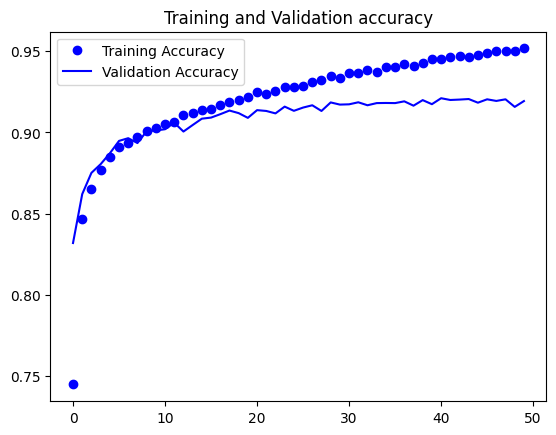

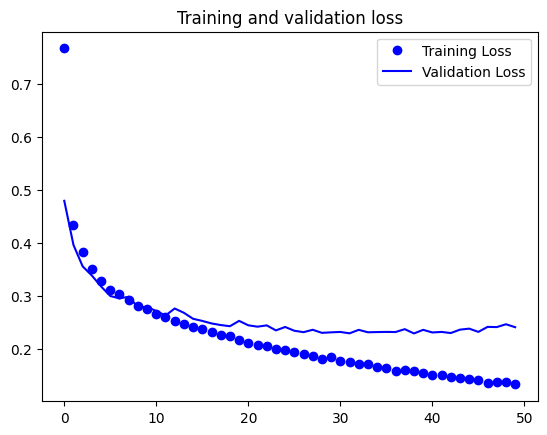

In [21]:
import matplotlib.pyplot as plt

%matplotlib inline

accuracy = history.history['accuracy']

val_accuracy = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')

plt.title('Training and Validation accuracy')

plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')

plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Training and validation loss')

plt.legend()

plt.show()

In [23]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming cnn_model.predict_classes(x_test) returns predicted classes
predicted_classes = np.argmax(cnn_model.predict(x_test), axis=-1)

# Assuming y_test contains the true labels
y_true = y_test

# Find correct and incorrect predictions
correct = np.where(predicted_classes == y_true)[0]
incorrect = np.where(predicted_classes != y_true)[0]

# Generate classification report
target_names = ["Class {}".format(i) for i in range(10)]  # Adjust based on your number of classes (Fashion-MNIST has 10 classes)
print(classification_report(y_true, predicted_classes, target_names=target_names))


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

     Class 0       0.87      0.86      0.87      1000
     Class 1       0.98      0.99      0.98      1000
     Class 2       0.86      0.88      0.87      1000
     Class 3       0.92      0.93      0.93      1000
     Class 4       0.88      0.89      0.89      1000
     Class 5       0.98      0.97      0.98      1000
     Class 6       0.80      0.75      0.78      1000
     Class 7       0.98      0.93      0.95      1000
     Class 8       0.98      0.98      0.98      1000
     Class 9       0.93      0.99      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



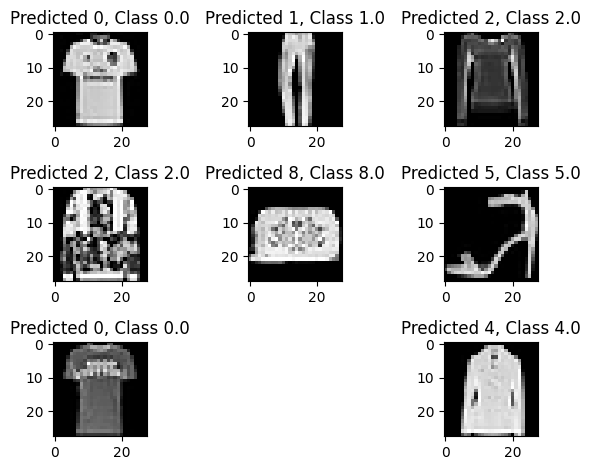

In [24]:
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_true[correct]))
    plt.tight_layout()

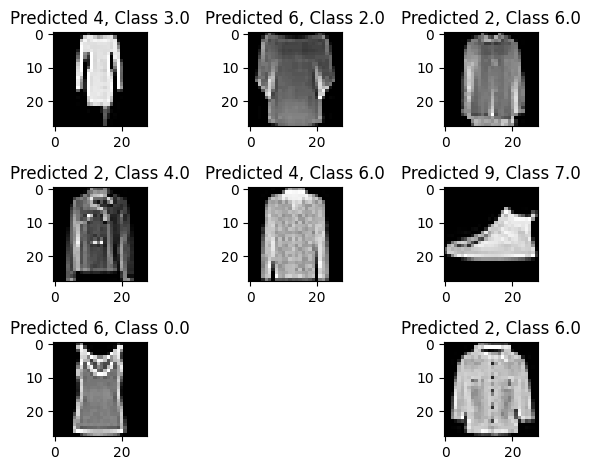

In [25]:
for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_true[incorrect]))
    plt.tight_layout()